In [ ]:
# !pip install shap

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [25]:
import os
# import shap
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# from modeling import FoldSet, GridSearch_ML, MLTest, RF_importances # ML
# import seaborn as sns
from modeling import MLTest
# from rnn_modeling import Make_DataSet, Search_RNN, Model_RNN # RNN
# from visualization import Result_pred, Monthly_plot, Hourly_plot, TimeBar, Correlation
# from visualization import Plot_Result, Result_RNN
# from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from math import ceil, sqrt

# Load

In [26]:
Mp_df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Mp.csv')
print(Mp_df.shape)
Mp_df

(36610, 13)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,2.6,6.0,290.0,91.0,1019.6,0.0,10.0,1300.0,9,2013-01-01,전남 목포시,20.16,1
1,4.2,5.8,250.0,82.0,1019.9,0.7,7.0,1300.0,10,2013-01-01,전남 목포시,106.80,1
2,3.8,7.1,320.0,80.0,1020.5,0.7,9.0,1300.0,11,2013-01-01,전남 목포시,469.56,1
3,4.9,2.8,290.0,73.0,1020.1,0.7,7.0,1300.0,12,2013-01-01,전남 목포시,504.24,1
4,5.2,6.7,320.0,66.0,1019.7,0.8,6.0,1100.0,13,2013-01-01,전남 목포시,745.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36605,-0.2,5.9,360.0,79.0,1031.4,0.2,9.0,1206.0,14,2021-12-31,전남 목포시,312.00,12
36606,-0.7,5.0,360.0,83.0,1031.4,0.0,10.0,1040.0,15,2021-12-31,전남 목포시,163.80,12
36607,-0.6,5.1,360.0,83.0,1031.5,0.0,10.0,1057.0,16,2021-12-31,전남 목포시,103.44,12
36608,0.6,6.9,360.0,69.0,1031.1,0.0,9.0,2000.0,17,2021-12-31,전남 목포시,45.36,12


In [27]:
Jd_df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Jd.csv')
print(Jd_df.shape)
Jd_df

(22447, 12)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Visibility,Time,Date,Area,Photovoltaics,Month
0,9.0,2.1,110.0,79.0,1024.1,0.0,2000.0,9,2015-01-25,전남 진도군,13680.0,1
1,10.4,3.0,110.0,77.0,1023.9,0.1,2000.0,10,2015-01-25,전남 진도군,115848.0,1
2,11.2,2.2,180.0,74.0,1023.9,0.0,2000.0,11,2015-01-25,전남 진도군,155016.0,1
3,12.6,1.9,180.0,71.0,1023.0,0.0,2000.0,12,2015-01-25,전남 진도군,175032.0,1
4,12.7,3.2,110.0,73.0,1021.7,0.0,2000.0,13,2015-01-25,전남 진도군,124560.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22442,0.4,1.6,50.0,80.0,1026.0,0.4,1991.0,13,2020-12-31,전남 진도군,210168.0,12
22443,1.6,4.0,320.0,78.0,1025.2,0.1,2000.0,14,2020-12-31,전남 진도군,84528.0,12
22444,2.0,4.4,270.0,67.0,1024.9,0.4,2000.0,15,2020-12-31,전남 진도군,122400.0,12
22445,1.6,5.4,320.0,75.0,1025.1,0.3,1755.0,16,2020-12-31,전남 진도군,129816.0,12


In [28]:
# Mokpo predict values
Mp_rnn =  pd.read_csv('/content/gdrive/MyDrive/SolarPower/Mokpo_rnn.csv', index_col=0)
Mp_rnn.drop(columns='train_mean', inplace=True)
Mp_ml =  pd.read_csv('/content/gdrive/MyDrive/SolarPower/Mokpo_pred.csv', index_col=0)
# Jindo predict values
Jd_rnn =  pd.read_csv('/content/gdrive/MyDrive/SolarPower/Jindo_rnn.csv', index_col=0)
Jd_rnn.drop(columns='train_mean', inplace=True)
Jd_ml =  pd.read_csv('/content/gdrive/MyDrive/SolarPower/Jindo_pred.csv', index_col=0)

In [29]:
Mp_pred = pd.merge(Mp_rnn, Mp_ml, on=['Area', 'Date', 'Month', 'Time','PV'])
print(Mp_pred.shape)

(4303, 11)


In [30]:
Jd_pred = pd.merge(Jd_rnn, Jd_ml, on=['Area', 'Date', 'Month', 'Time','PV'])
print(Jd_pred.shape)

(3743, 11)


# Model Comparison

In [31]:
def Scatter_plot(pred_df, fig):

  pred_cols = [i for i in pred_df.columns if i not in ['Area', 'Date', 'Month', 'Time']]

  # 일별 합
  date = pred_df['Date'].unique()
  day_df = pd.DataFrame(date, columns=['Date'])
  sum_list = []
  for day in date:
    pv_sum = pred_df[pred_df['Date'] == day][pred_cols].sum()
    sum_list.append(pv_sum)
  data = pd.DataFrame(sum_list)
  sum_df = pd.concat([day_df, data], axis=1)

  # plot
  min_num = sum_df.iloc[:,1:][pred_cols].min().min()
  max_num = sum_df.iloc[:,1:][pred_cols].max().max()
  max_num = ceil(max_num)

  color_list = ['r','b','gray','k','y','g']

  for idx, col in enumerate(pred_cols[1:]):
    ax = fig.subplot(3,3, idx+1)
    cols = ['PV', f'{col}']
    ax.scatter(sum_df['PV'], sum_df[col], color=color_list[idx], s=9, alpha=0.8)
    ax.plot(range(0, max_num), range(0,max_num), color='grey')
    ax.set_xlabel(cols[0], fontsize=12)
    ax.set_ylabel(cols[1], fontsize=12)
    ax.legend(cols, bbox_to_anchor=(0.6,1), loc='upper right', ncol=len(cols), fontsize=10)

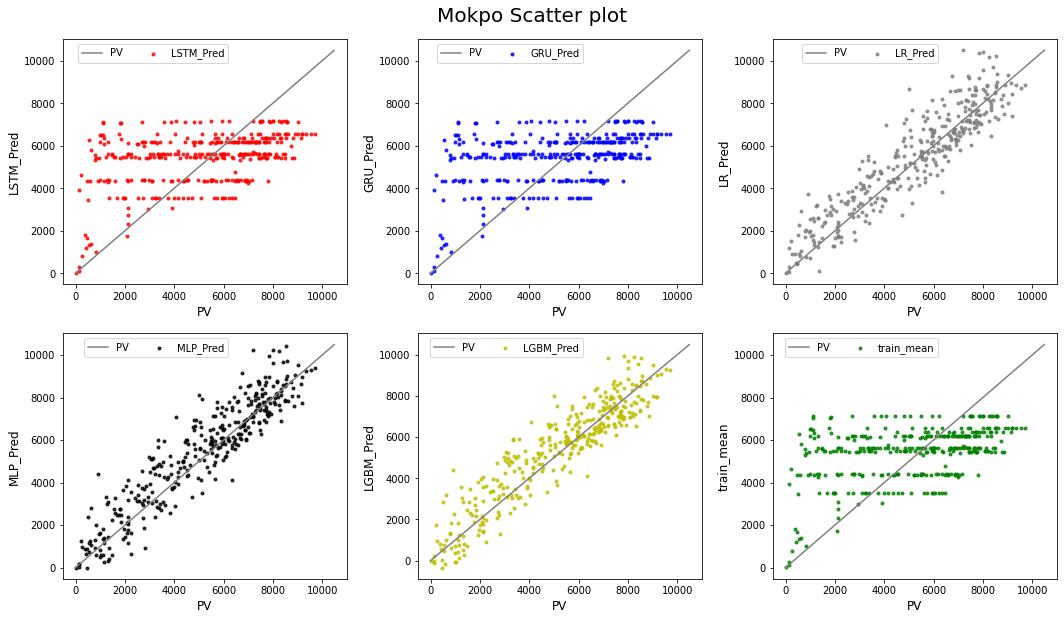

In [32]:
plt.figure(figsize=(15,12))
plt.suptitle('Mokpo Scatter plot', y=1.02, x=0.5, fontsize=20)
Scatter_plot(Mp_pred, plt)
plt.tight_layout(pad=1.5)
plt.show()

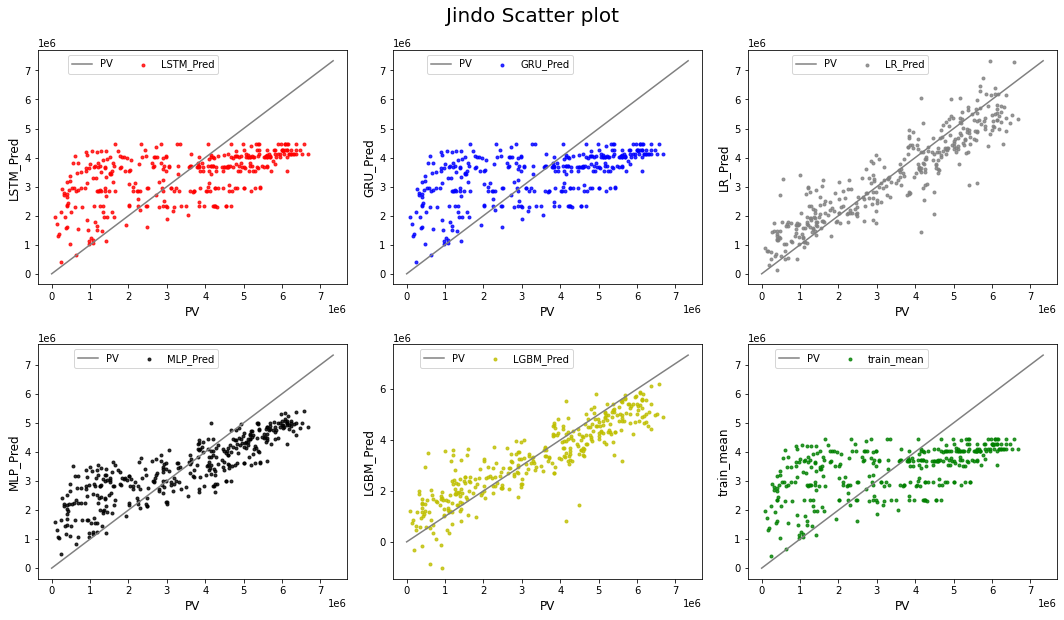

In [33]:
plt.figure(figsize=(15,12))
plt.suptitle('Jindo Scatter plot', y=1.02, x=0.5, fontsize=20)
Scatter_plot(Jd_pred, plt)
plt.tight_layout(pad=1.5)
plt.show()

# best model (LGBM)

In [34]:
Jd_cols = [x for x in Jd_df.columns if x not in ['Date','Area','Month','Time','Year']]
Mp_cols = [x for x in Mp_df.columns if x not in ['Date','Area','Month','Time','Year']]

In [35]:
Jd_params, Mp_params = {},{}
Jd_params['dev_LGBM'] = {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
Mp_params['dev_LGBM'] = {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 35, 'objective': 'regression'}

In [36]:
Mp_score = {}
Mp_Shap_dic = {}
Mp_LGBM = MLTest(Mp_df, 'LGBM', Mp_params, Mp_score, Mp_Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

train: (5382, 8), (5382, 1) valid: (5381, 8), (5381, 1)

train: (10763, 8), (10763, 1) valid: (5381, 8), (5381, 1)

train: (16144, 8), (16144, 1) valid: (5381, 8), (5381, 1)

train: (21525, 8), (21525, 1) valid: (5381, 8), (5381, 1)

train: (26906, 8), (26906, 1) valid: (5381, 8), (5381, 1)



In [37]:
Jd_score = {}
Jd_Shap_dic = {}
Jd_LGBM = MLTest(Jd_df, 'LGBM', Jd_params, Jd_score, Jd_Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)



In [38]:
print(f'LGBM Model Score for PV Prediction\n')
print(f'Jindo :\n{Jd_score}\n')
print(f'Mokpo :\n{Mp_score}')

LGBM Model Score for PV Prediction

Jindo :
{'EVS_dev_LGBM': 0.7789937217539469, 'MAPE_dev_LGBM': 0.8274905247949578}

Mokpo :
{'EVS_dev_LGBM': 0.8349489003733397, 'MAPE_dev_LGBM': 4.1150458421698906}


# Predict values plot
 Compare actual and predicted values

In [39]:
pred_cols = ['PV','LSTM_Pred', 'GRU_Pred', 'LR_Pred', 'MLP_Pred', 'LGBM_Pred', 'train_mean']

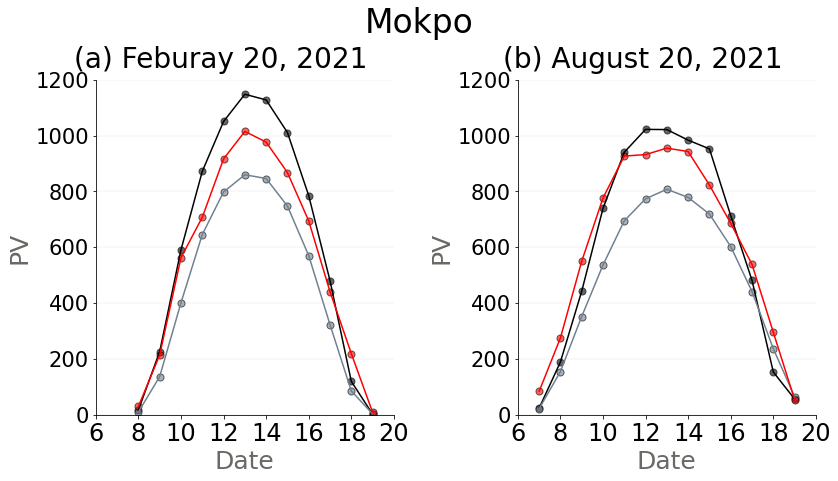

In [44]:
fig = plt.figure(figsize=(12, 6.5))
fig.suptitle('Mokpo', fontsize=33, y=1.04)

plot_cols = ['PV', 'train_mean', 'LGBM_Pred']
max_pv = Mp_pred[plot_cols].max().max()

for m_idx, m in enumerate([2,8]):
  ax = fig.add_subplot(1, 2, m_idx+1)
  if m < 10 :
    date = f'2021-0{m}-20'
  else:
    date = f'2021-{m}-20'

  day_df = Mp_pred[Mp_pred['Date']==date]
  t_list = day_df['Time'].unique()

  #Plot
  axtitle = ['(a) Feburay 20, 2021', '(b) August 20, 2021']
  color_list = ['K','slategrey','r']
  for col_idx, i in enumerate(plot_cols):
    ax.plot(np.sort(t_list), day_df[i], color=color_list[col_idx])
    ax.scatter(np.sort(t_list), day_df[i], color=color_list[col_idx], alpha=0.6, edgecolors='k', linewidth=1, s=50)
  ax.set_title(axtitle[m_idx], fontsize=28, pad=12, x=0.42)

  ax.set_xlabel('Date', fontsize=25, color='#696965')
  ax.set_ylabel('PV', fontsize=25, color='#696965')
  ax.set_xticks(np.arange(6,21,2))
  ax.set_xticklabels(np.arange(6,21,2),fontsize=24)
  ax.set_yticks(np.arange(0,1300,200))
  ax.set_yticklabels(np.arange(0,1300,200), fontsize=21)
  ax.set_ylim(0, 1200)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.grid(axis='y', color='#696965', linewidth=0.2, linestyle=':')
plt.tight_layout(pad=2)
plt.savefig('predplot_Mokpo.png', dpi=500, bbox_inches='tight')

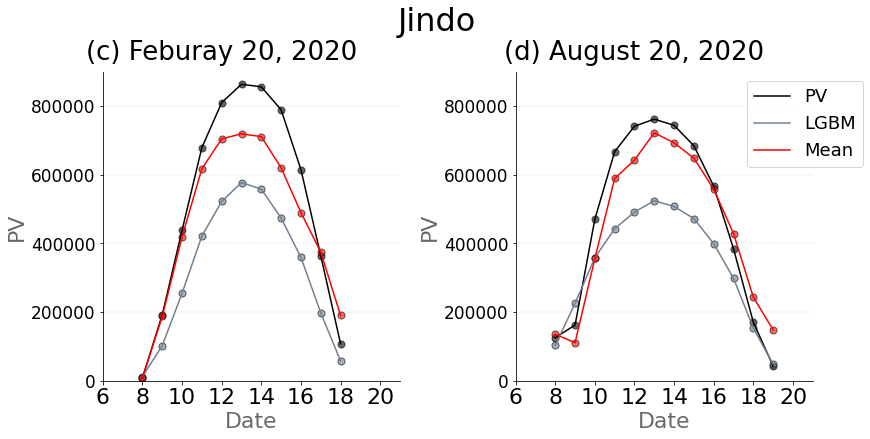

In [46]:
fig = plt.figure(figsize=(12.5, 6))
fig.suptitle('Jindo', fontsize=32, y=1.03)

plot_cols = ['PV', 'train_mean', 'LGBM_Pred']
max_pv = Jd_pred[plot_cols].max().max()

for m_idx, m in enumerate([2,8]):
  ax = fig.add_subplot(1,2,m_idx+1)
  if m < 10 :
    date = f'2020-0{m}-20'
  else:
    date = f'2020-{m}-20'

  day_df = Jd_pred[Jd_pred['Date']==date]
  t_list = day_df['Time'].unique()

  #Plot
  axtitle = ['(c) Feburay 20, 2020', '(d) August 20, 2020']
  color_list = ['K','slategrey','r']
  for col_idx, i in enumerate(plot_cols):
    ax.plot(np.sort(t_list), day_df[i], color=color_list[col_idx])
    ax.scatter(np.sort(t_list), day_df[i], color=color_list[col_idx], alpha=0.6, edgecolors='k', linewidth=1, s=50)
  ax.set_title(axtitle[m_idx], fontsize=26, pad=12, x=0.4)
  if m == 8:
    ax.legend(['PV','LGBM','Mean'], loc='upper right',bbox_to_anchor = (1.2,1), fontsize=18)
  ax.set_xlabel('Date', fontsize=22, color='#696965')
  ax.set_ylabel('PV', fontsize=22, color='#696965')
  ax.set_xlim(6,21)
  ax.set_xticks(np.arange(6,21,2))
  ax.set_xticklabels(np.arange(6,21,2),fontsize=22)
  ax.set_yticks(np.arange(0,900000,200000))
  ax.set_yticklabels(np.arange(0,900000,200000), fontsize=17)
  ax.set_ylim(0,900000)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.grid(axis='y', color='#696965', linewidth=0.2, linestyle=':')
plt.tight_layout(pad=2)
plt.savefig('predplot_Jindo.png', dpi=500, bbox_inches='tight')

# SHAP

In [ ]:
def Shap_bar(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train)
  shap_values = explainer(x_train)

  return shap_values, x_train

In [ ]:
shap_Mp, Mp_train = Shap_bar(**Mp_Shap_dic['dev_LGBM'])

Exact explainer: 32288it [47:26, 11.32it/s]


In [ ]:
shap_Jd, Jd_train = Shap_bar(**Jd_Shap_dic['dev_LGBM'])

Exact explainer: 18685it [08:57, 34.05it/s]                           


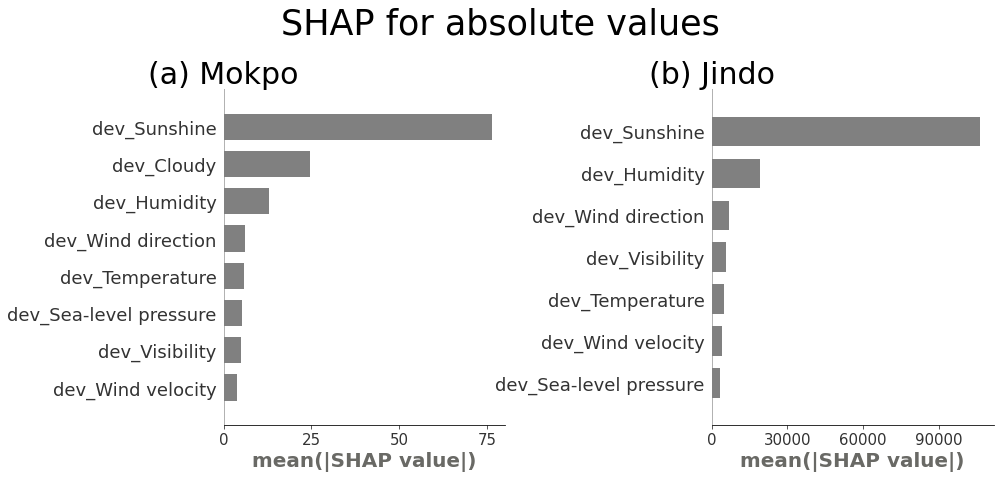

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.summary_plot(shap_Mp, Mp_train, plot_type='bar', show=False, color='grey')
ax0.set_title('(a) Mokpo', x=0, pad=0, fontsize=30)
ax0.set_xlabel('mean(|SHAP value|)', fontsize=20, color='#696965', fontweight='semibold')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=18)
ax0.set_xticks(np.arange(0, int(ax0.get_xticks().max()),40))
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)


ax1 = fig.add_subplot(122)
shap.summary_plot(shap_Jd, Jd_train, plot_type='bar', show=False, color='grey')
ax1.set_title('(b) Jindo', x=0, pad=0, fontsize=30)
ax1.set_xlabel('mean(|SHAP value|)', fontsize=20, color='#696965', fontweight='semibold')
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=18)
ax1.set_xticks(np.arange(0,120000,30000))
ax1.set_xticklabels(np.arange(0,120000,30000), fontsize=15)


plt.gcf().set_size_inches(14,6)
plt.suptitle('SHAP for absolute values',y=1.1, x=0.5, fontsize=35)
plt.tight_layout(h_pad=1, w_pad=-1)
plt.savefig('shap1.png', bbox_inches='tight', dpi=500)
plt.show()

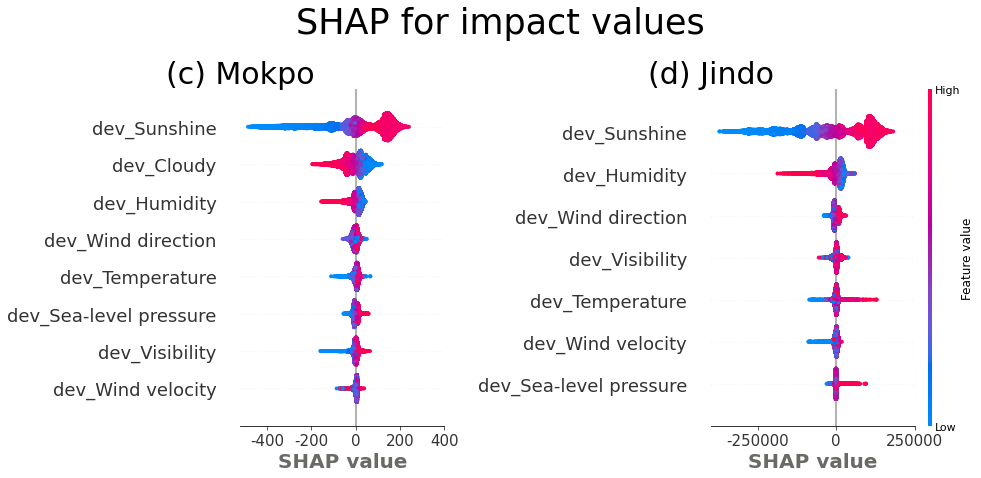

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.summary_plot(shap_Mp, Mp_train, show=False)
ax0.set_title('(c) Mokpo', x=0, pad=0, fontsize=30)
ax0.set_xlabel('SHAP value', fontsize=20, color='#696965', fontweight='semibold')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=18)
ax0.set_xticks([-400, -200, 0, 200, 400])
ax0.set_xticklabels([-400, -200, 0, 200, 400], fontsize=15)
cbar = fig.get_children()[-1]
cbar.remove()

ax1 = fig.add_subplot(122)
shap.summary_plot(shap_Jd, Jd_train, show=False)
ax1.set_title('(d) Jindo', x=0, pad=0, fontsize=30)
ax1.set_xlabel('SHAP value', fontsize=20, color='#696965', fontweight='semibold')
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=18)
ax1.set_xticks([-250000, 0, 250000])
ax1.set_xticklabels([-250000, 0, 250000], fontsize=15)

plt.gcf().set_size_inches(14,6)
plt.suptitle('SHAP for impact values',y=1.1, x=0.5, fontsize=35)
plt.tight_layout(h_pad=1, w_pad=-1)
plt.savefig('shap2.png', bbox_inches='tight', dpi=500)
plt.show()

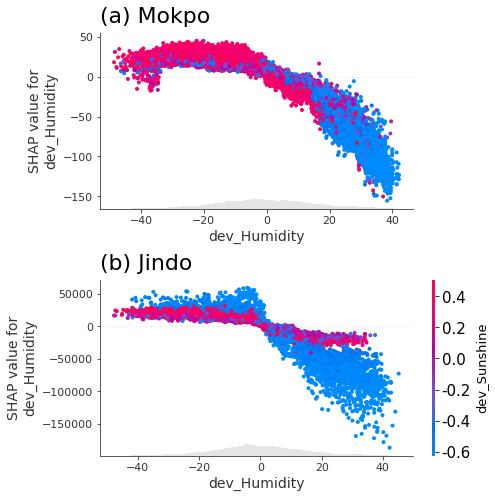

In [ ]:
ㄷㄷfig, (ax1, ax2) = plt.subplots(figsize=(7,7), ncols=1, nrows=2)

ax1.set_title('(a) Mokpo', loc='left', pad=10, fontsize=22)
shap.plots.scatter(shap_Mp[:,'dev_Humidity'], color=shap_Mp[:,'dev_Sunshine'], ax=ax1, show=False)
ax1.set_ylabel(ax1.get_ylabel(), fontsize=14)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=14)

cbar = fig.get_children()[-2]
cbar.remove()

ax2.set_title('(b) Jindo', loc='left', pad=10, fontsize=22)
shap.plots.scatter(shap_Jd[:,'dev_Humidity'], color=shap_Jd[:,'dev_Sunshine'], ax=ax2, show=False)
ax2.set_ylabel(ax2.get_ylabel(), fontsize=14)
ax2.set_xlabel(ax2.get_xlabel(), fontsize=14)

cbar = fig.get_children()[-2]
cbar.set_yticklabels([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4], fontsize=15)

plt.tight_layout(pad=1)
plt.savefig('shap_variable2.png', bbox_inches='tight', dpi=500)
plt.show()